<a href="https://colab.research.google.com/github/we-make-ai/welcome2ki-3/blob/main/10_Image_Regression_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fastai --upgrade -q
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.all import *

     |████████████████████████████████| 194kB 8.9MB/s 
     |████████████████████████████████| 51kB 7.5MB/s 
     |████████████████████████████████| 727kB 7.5MB/s 
     |████████████████████████████████| 51kB 9.4MB/s 
     |████████████████████████████████| 51kB 8.4MB/s 
     |████████████████████████████████| 1.1MB 15.6MB/s 
     |████████████████████████████████| 92kB 12.0MB/s 
     |████████████████████████████████| 40kB 8.0MB/s 
     |████████████████████████████████| 51kB 9.6MB/s 
     |████████████████████████████████| 61kB 10.3MB/s 
     |████████████████████████████████| 2.6MB 29.6MB/s 
Mounted at /content/gdrive


#Regression Model
## Unser Datenset
Wir verwenden das [Biwi Kinect Head Pose Datenset](https://icu.ee.ethz.ch/research/datsets.html).

In [ ]:
path = untar_data(URLs.BIWI_HEAD_POSE)
Path.BASE_PATH = path
path.ls().sorted()

(#50) [Path('01'),Path('01.obj'),Path('02'),Path('02.obj'),Path('03'),Path('03.obj'),Path('04'),Path('04.obj'),Path('05'),Path('05.obj')...]

In [ ]:
(path/'01').ls().sorted()

(#1000) [Path('01/depth.cal'),Path('01/frame_00003_pose.txt'),Path('01/frame_00003_rgb.jpg'),Path('01/frame_00004_pose.txt'),Path('01/frame_00004_rgb.jpg'),Path('01/frame_00005_pose.txt'),Path('01/frame_00005_rgb.jpg'),Path('01/frame_00006_pose.txt'),Path('01/frame_00006_rgb.jpg'),Path('01/frame_00007_pose.txt')...]

In [ ]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('03/frame_00149_pose.txt')

In [ ]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

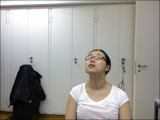

In [ ]:
im.to_thumb(160)

In [ ]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [ ]:
get_ctr(img_files[0])

tensor([383.6775, 241.7145])

In [ ]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240,320)), 
                Normalize.from_stats(*imagenet_stats)]
)

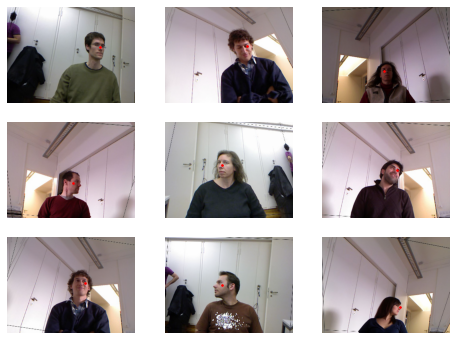

In [ ]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [ ]:
xb,yb = dls.one_batch()
xb.shape,yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [ ]:
yb[0]

TensorPoint([[-0.0176, -0.0005]], device='cuda:0')

## Erstellen des Learners

In [ ]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
def sigmoid_range(x, lo, hi): return torch.sigmoid(x) * (hi-lo) + lo

/usr/local/lib/python3.6/dist-packages/fastbook/__init__.py:55: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /pytorch/aten/src/ATen/native/RangeFactories.cpp:23.)
  x = torch.linspace(min,max)


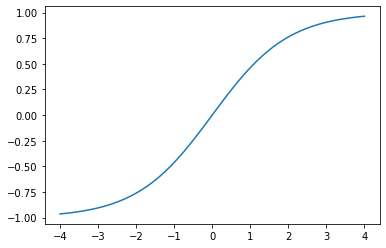

In [ ]:
plot_function(partial(sigmoid_range,lo=-1,hi=1), min=-4, max=4)

In [ ]:
dls.loss_func

FlattenedLoss of MSELoss()

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=4.786300905834651e-06)

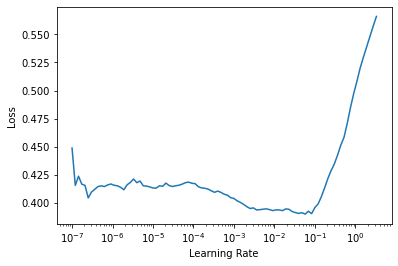

In [ ]:
learn.lr_find()

In [ ]:
lr = 1e-2
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,time
0,0.047242,0.019327,02:00


epoch,train_loss,valid_loss,time
0,0.007986,0.002107,02:11
1,0.002902,0.000285,02:12
2,0.001403,0.000100,02:13


In [ ]:
math.sqrt(0.0001)

0.01

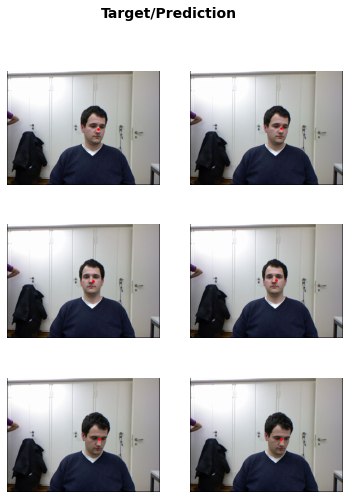

In [ ]:
learn.show_results(ds_idx=1, nrows=3, figsize=(6,8))